<a href="https://colab.research.google.com/github/koDELLL/MachineLearning/blob/main/WEEK%2011/Heart_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Untuk mengabilkan dataset dari google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch

In [ ]:
# Import library yang dibutuhkan
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
# 1. Load Dataset dan Preprocessing
# Load dataset heart disease
data_path = '/content/drive/MyDrive/heart.csv'
df = pd.read_csv(data_path)
print("Dataset preview:")
print(df.head())  # Menampilkan beberapa baris pertama dataset

# Pisahkan fitur dan label
X = df.drop('thal', axis=1).values  # Semua kolom kecuali 'target'
y = df['thal'].values  # Kolom target (label)

# Pastikan label hanya 0 dan 1
print("Unique target labels before processing:", np.unique(y))
y = np.where(y > 1, 1, y)  # Pastikan label lebih dari 1 menjadi 1
print("Unique target labels after processing:", np.unique(y))

# Normalisasi fitur menggunakan StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Pisahkan data menjadi training dan test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Buat Dataset PyTorch
class HeartDiseaseDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = HeartDiseaseDataset(X_train, y_train)
test_dataset = HeartDiseaseDataset(X_test, y_test)

Dataset preview:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0  
Unique target labels before processing: [0 1 2 3]
Unique target labels after processing: [0 1]


In [ ]:
# 2. Bangun Model MLP
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers, neurons, activation_fn):
        super(MLP, self).__init__()
        layers = []
        current_input_size = input_size

        # Tambahkan hidden layers sesuai jumlah layer dan neuron
        for _ in range(hidden_layers):
            layers.append(nn.Linear(current_input_size, neurons))
            if activation_fn == 'relu':
                layers.append(nn.ReLU())
            elif activation_fn == 'sigmoid':
                layers.append(nn.Sigmoid())
            elif activation_fn == 'tanh':
                layers.append(nn.Tanh())
            elif activation_fn == 'linear':
                pass  # Linear berarti tidak ada aktivasi
            current_input_size = neurons

        # Layer output
        layers.append(nn.Linear(current_input_size, 2))  # Output 2 kelas: 0 atau 1
        layers.append(nn.Softmax(dim=1))  # Softmax untuk klasifikasi multi-kelas

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)


In [ ]:
# 3. Fungsi untuk Latih Model
def train_model(hidden_layers, neurons, activation_fn, epochs, lr, batch_size):
    input_size = X.shape[1]  # Jumlah fitur
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Definisi model, loss function, dan optimizer
    model = MLP(input_size, hidden_layers, neurons, activation_fn)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training loop
    train_losses = []
    test_losses = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()  # Reset gradient
            outputs = model(X_batch)  # Forward pass
            loss = criterion(outputs, y_batch)  # Hitung loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update parameter
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluasi model
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                test_loss += loss.item()
        avg_test_loss = test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

    return train_losses, test_losses

In [ ]:
# 4. Eksperimen Hyperparameter dan Visualisasi
hidden_layers_list = [1, 2, 3]
neurons_list = [4, 8, 16, 32, 64]
activation_functions = ['relu', 'sigmoid', 'tanh', 'linear']
epochs_list = [1, 10, 25, 50, 100]
learning_rates = [10, 1, 0.1, 0.01, 0.001, 0.0001]
batch_sizes = [16, 32, 64, 128, 256, 512]



In [ ]:
train_losses, test_losses = train_model(
    hidden_layers=3,
    neurons=64,
    activation_fn='relu',
    epochs=50,
    lr=0.01,
    batch_size=16
    )

Epoch [1/50], Train Loss: 0.3353, Test Loss: 0.3373
Epoch [2/50], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [3/50], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [4/50], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [5/50], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [6/50], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [7/50], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [8/50], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [9/50], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [10/50], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [11/50], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [12/50], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [13/50], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [14/50], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [15/50], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [16/50], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [17/50], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [18/50], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [19/50], Train Loss: 0.3157, Test Loss: 0.3373
Ep

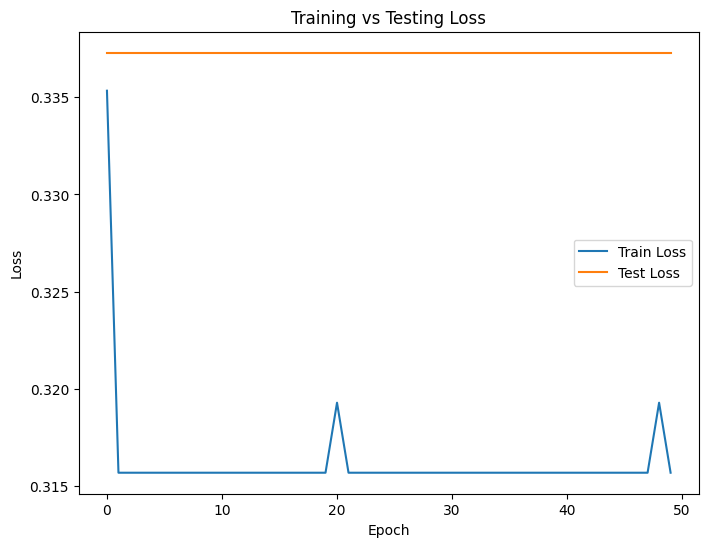

In [ ]:
# Visualisasi hasil training
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Testing Loss')
plt.legend()
plt.show()

In [ ]:
train_losses, test_losses = train_model(
    hidden_layers=1,
    neurons=8,
    activation_fn='relu',
    epochs=100,
    lr=10,
    batch_size=512
    )

Epoch [1/100], Train Loss: 0.4663, Test Loss: 0.3377
Epoch [2/100], Train Loss: 0.3165, Test Loss: 0.3377
Epoch [3/100], Train Loss: 0.3152, Test Loss: 0.3377
Epoch [4/100], Train Loss: 0.3152, Test Loss: 0.3377
Epoch [5/100], Train Loss: 0.3159, Test Loss: 0.3377
Epoch [6/100], Train Loss: 0.3165, Test Loss: 0.3377
Epoch [7/100], Train Loss: 0.3159, Test Loss: 0.3377
Epoch [8/100], Train Loss: 0.3152, Test Loss: 0.3377
Epoch [9/100], Train Loss: 0.3152, Test Loss: 0.3377
Epoch [10/100], Train Loss: 0.3152, Test Loss: 0.3377
Epoch [11/100], Train Loss: 0.3159, Test Loss: 0.3377
Epoch [12/100], Train Loss: 0.3159, Test Loss: 0.3377
Epoch [13/100], Train Loss: 0.3165, Test Loss: 0.3377
Epoch [14/100], Train Loss: 0.3152, Test Loss: 0.3377
Epoch [15/100], Train Loss: 0.3165, Test Loss: 0.3377
Epoch [16/100], Train Loss: 0.3159, Test Loss: 0.3377
Epoch [17/100], Train Loss: 0.3159, Test Loss: 0.3377
Epoch [18/100], Train Loss: 0.3152, Test Loss: 0.3377
Epoch [19/100], Train Loss: 0.3152, T

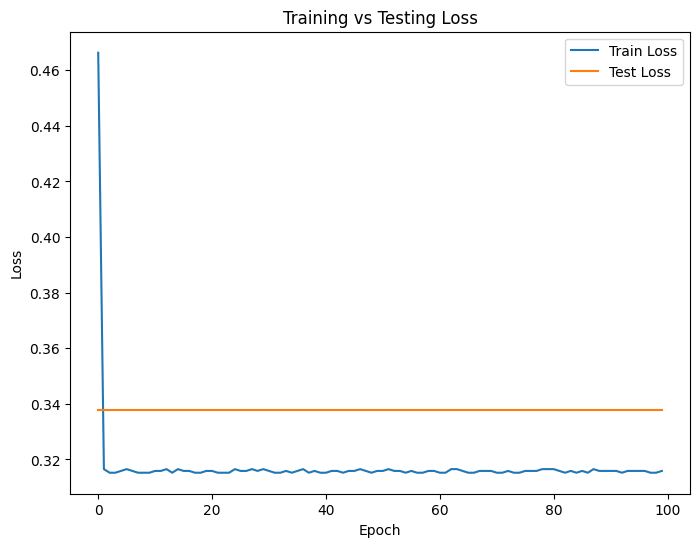

In [ ]:
# Visualisasi hasil training
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Testing Loss')
plt.legend()
plt.show()

In [ ]:
train_losses, test_losses = train_model(
    hidden_layers=1,
    neurons=4,
    activation_fn='relu',
    epochs=25,
    lr=0.0001,
    batch_size=512
    )

Epoch [1/25], Train Loss: 0.5981, Test Loss: 0.6117
Epoch [2/25], Train Loss: 0.5973, Test Loss: 0.6114
Epoch [3/25], Train Loss: 0.5961, Test Loss: 0.6110
Epoch [4/25], Train Loss: 0.5971, Test Loss: 0.6107
Epoch [5/25], Train Loss: 0.5964, Test Loss: 0.6103
Epoch [6/25], Train Loss: 0.5950, Test Loss: 0.6100
Epoch [7/25], Train Loss: 0.5943, Test Loss: 0.6096
Epoch [8/25], Train Loss: 0.5948, Test Loss: 0.6093
Epoch [9/25], Train Loss: 0.5961, Test Loss: 0.6090
Epoch [10/25], Train Loss: 0.5968, Test Loss: 0.6086
Epoch [11/25], Train Loss: 0.5932, Test Loss: 0.6083
Epoch [12/25], Train Loss: 0.5952, Test Loss: 0.6079
Epoch [13/25], Train Loss: 0.5939, Test Loss: 0.6076
Epoch [14/25], Train Loss: 0.5935, Test Loss: 0.6073
Epoch [15/25], Train Loss: 0.5920, Test Loss: 0.6069
Epoch [16/25], Train Loss: 0.5927, Test Loss: 0.6066
Epoch [17/25], Train Loss: 0.5923, Test Loss: 0.6063
Epoch [18/25], Train Loss: 0.5914, Test Loss: 0.6059
Epoch [19/25], Train Loss: 0.5919, Test Loss: 0.6056
Ep

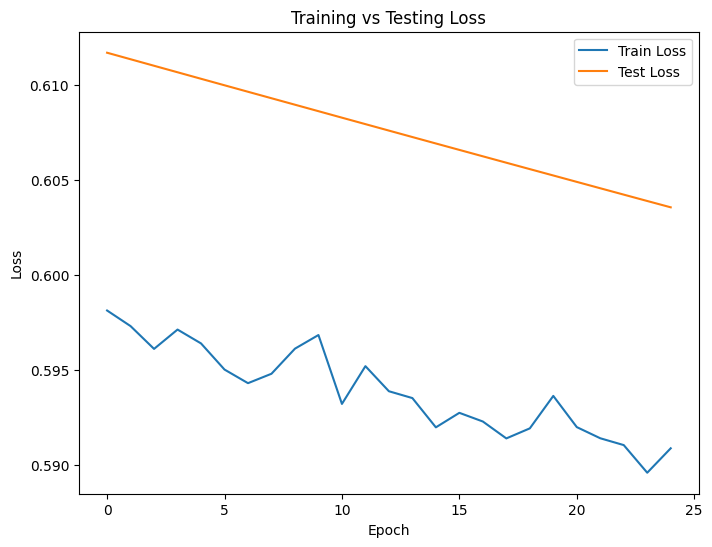

In [ ]:
# Visualisasi hasil training
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Testing Loss')
plt.legend()
plt.show()

In [ ]:
train_losses, test_losses = train_model(
    hidden_layers=3,
    neurons=4,
    activation_fn='sigmoid',
    epochs=50,
    lr=0.0001,
    batch_size=512
    )

Epoch [1/50], Train Loss: 0.7394, Test Loss: 0.7371
Epoch [2/50], Train Loss: 0.7390, Test Loss: 0.7367
Epoch [3/50], Train Loss: 0.7385, Test Loss: 0.7363
Epoch [4/50], Train Loss: 0.7381, Test Loss: 0.7360
Epoch [5/50], Train Loss: 0.7377, Test Loss: 0.7356
Epoch [6/50], Train Loss: 0.7373, Test Loss: 0.7352
Epoch [7/50], Train Loss: 0.7369, Test Loss: 0.7348
Epoch [8/50], Train Loss: 0.7366, Test Loss: 0.7344
Epoch [9/50], Train Loss: 0.7361, Test Loss: 0.7341
Epoch [10/50], Train Loss: 0.7357, Test Loss: 0.7337
Epoch [11/50], Train Loss: 0.7353, Test Loss: 0.7333
Epoch [12/50], Train Loss: 0.7349, Test Loss: 0.7329
Epoch [13/50], Train Loss: 0.7346, Test Loss: 0.7325
Epoch [14/50], Train Loss: 0.7342, Test Loss: 0.7321
Epoch [15/50], Train Loss: 0.7338, Test Loss: 0.7318
Epoch [16/50], Train Loss: 0.7334, Test Loss: 0.7314
Epoch [17/50], Train Loss: 0.7330, Test Loss: 0.7310
Epoch [18/50], Train Loss: 0.7326, Test Loss: 0.7306
Epoch [19/50], Train Loss: 0.7322, Test Loss: 0.7302
Ep

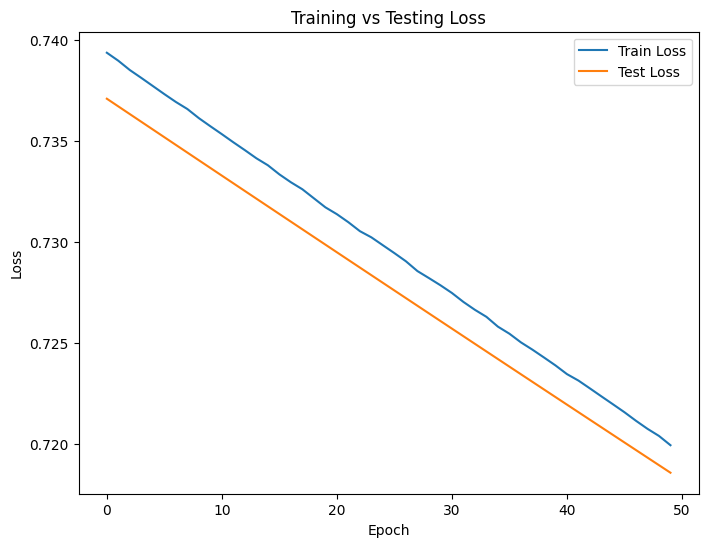

In [ ]:
# Visualisasi hasil training
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Testing Loss')
plt.legend()
plt.show()

In [ ]:
train_losses, test_losses = train_model(
    hidden_layers=3,
    neurons=64,
    activation_fn='sigmoid',
    epochs=100,
    lr=1,
    batch_size=256
    )

Epoch [1/100], Train Loss: 0.4469, Test Loss: 0.3377
Epoch [2/100], Train Loss: 0.3152, Test Loss: 0.3377
Epoch [3/100], Train Loss: 0.3152, Test Loss: 0.3377
Epoch [4/100], Train Loss: 0.3152, Test Loss: 0.3377
Epoch [5/100], Train Loss: 0.3152, Test Loss: 0.3377
Epoch [6/100], Train Loss: 0.3152, Test Loss: 0.3377
Epoch [7/100], Train Loss: 0.3152, Test Loss: 0.3377
Epoch [8/100], Train Loss: 0.3152, Test Loss: 0.3377
Epoch [9/100], Train Loss: 0.3152, Test Loss: 0.3377
Epoch [10/100], Train Loss: 0.3190, Test Loss: 0.3377
Epoch [11/100], Train Loss: 0.3152, Test Loss: 0.3377
Epoch [12/100], Train Loss: 0.3152, Test Loss: 0.3377
Epoch [13/100], Train Loss: 0.3152, Test Loss: 0.3377
Epoch [14/100], Train Loss: 0.3152, Test Loss: 0.3377
Epoch [15/100], Train Loss: 0.3152, Test Loss: 0.3377
Epoch [16/100], Train Loss: 0.3152, Test Loss: 0.3377
Epoch [17/100], Train Loss: 0.3152, Test Loss: 0.3377
Epoch [18/100], Train Loss: 0.3152, Test Loss: 0.3377
Epoch [19/100], Train Loss: 0.3152, T

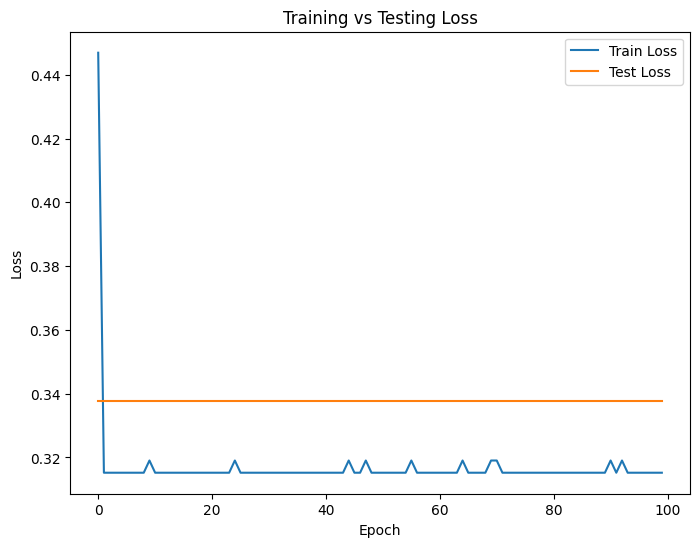

In [ ]:
# Visualisasi hasil training
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Testing Loss')
plt.legend()
plt.show()

In [ ]:
train_losses, test_losses = train_model(
    hidden_layers=3,
    neurons=32,
    activation_fn='sigmoid',
    epochs=50,
    lr=10,
    batch_size=128
    )

Epoch [1/50], Train Loss: 0.3544, Test Loss: 0.3380
Epoch [2/50], Train Loss: 0.3155, Test Loss: 0.3380
Epoch [3/50], Train Loss: 0.3155, Test Loss: 0.3380
Epoch [4/50], Train Loss: 0.3155, Test Loss: 0.3380
Epoch [5/50], Train Loss: 0.3155, Test Loss: 0.3380
Epoch [6/50], Train Loss: 0.3155, Test Loss: 0.3380
Epoch [7/50], Train Loss: 0.3155, Test Loss: 0.3380
Epoch [8/50], Train Loss: 0.3155, Test Loss: 0.3380
Epoch [9/50], Train Loss: 0.3155, Test Loss: 0.3380
Epoch [10/50], Train Loss: 0.3155, Test Loss: 0.3380
Epoch [11/50], Train Loss: 0.3155, Test Loss: 0.3380
Epoch [12/50], Train Loss: 0.3155, Test Loss: 0.3380
Epoch [13/50], Train Loss: 0.3155, Test Loss: 0.3380
Epoch [14/50], Train Loss: 0.3155, Test Loss: 0.3380
Epoch [15/50], Train Loss: 0.3155, Test Loss: 0.3380
Epoch [16/50], Train Loss: 0.3155, Test Loss: 0.3380
Epoch [17/50], Train Loss: 0.3155, Test Loss: 0.3380
Epoch [18/50], Train Loss: 0.3155, Test Loss: 0.3380
Epoch [19/50], Train Loss: 0.3155, Test Loss: 0.3380
Ep

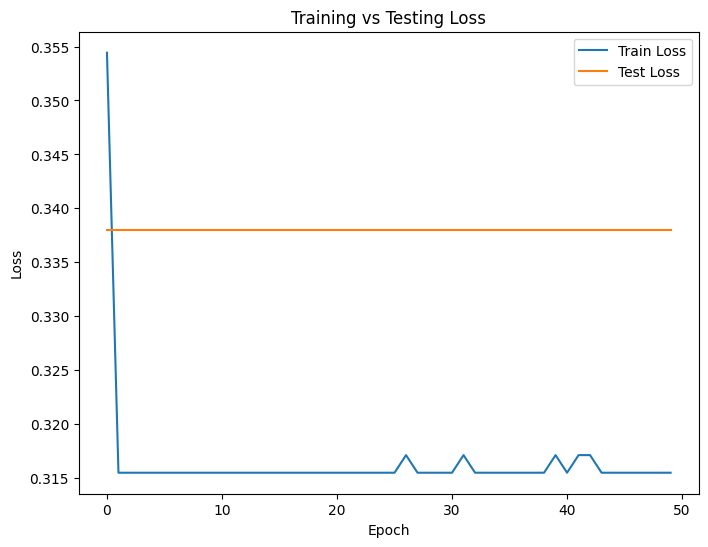

In [ ]:
# Visualisasi hasil training
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Testing Loss')
plt.legend()
plt.show()

In [ ]:
train_losses, test_losses = train_model(
    hidden_layers=2,
    neurons=16,
    activation_fn='sigmoid',
    epochs=25,
    lr=0.1,
    batch_size=64
    )

Epoch [1/25], Train Loss: 0.3317, Test Loss: 0.3328
Epoch [2/25], Train Loss: 0.3157, Test Loss: 0.3328
Epoch [3/25], Train Loss: 0.3157, Test Loss: 0.3328
Epoch [4/25], Train Loss: 0.3157, Test Loss: 0.3328
Epoch [5/25], Train Loss: 0.3157, Test Loss: 0.3328
Epoch [6/25], Train Loss: 0.3157, Test Loss: 0.3328
Epoch [7/25], Train Loss: 0.3157, Test Loss: 0.3328
Epoch [8/25], Train Loss: 0.3157, Test Loss: 0.3328
Epoch [9/25], Train Loss: 0.3157, Test Loss: 0.3328
Epoch [10/25], Train Loss: 0.3159, Test Loss: 0.3328
Epoch [11/25], Train Loss: 0.3157, Test Loss: 0.3328
Epoch [12/25], Train Loss: 0.3159, Test Loss: 0.3328
Epoch [13/25], Train Loss: 0.3159, Test Loss: 0.3328
Epoch [14/25], Train Loss: 0.3157, Test Loss: 0.3328
Epoch [15/25], Train Loss: 0.3157, Test Loss: 0.3328
Epoch [16/25], Train Loss: 0.3157, Test Loss: 0.3328
Epoch [17/25], Train Loss: 0.3159, Test Loss: 0.3328
Epoch [18/25], Train Loss: 0.3157, Test Loss: 0.3328
Epoch [19/25], Train Loss: 0.3159, Test Loss: 0.3328
Ep

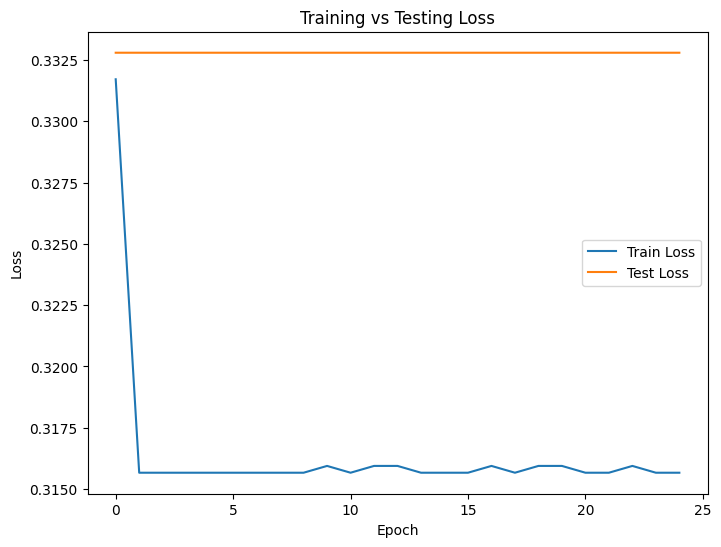

In [ ]:
# Visualisasi hasil training
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Testing Loss')
plt.legend()
plt.show()

In [ ]:
train_losses, test_losses = train_model(
    hidden_layers=2,
    neurons=8,
    activation_fn='sigmoid',
    epochs=10,
    lr=1,
    batch_size=32
    )

Epoch [1/10], Train Loss: 0.3284, Test Loss: 0.3356
Epoch [2/10], Train Loss: 0.3157, Test Loss: 0.3356
Epoch [3/10], Train Loss: 0.3157, Test Loss: 0.3356
Epoch [4/10], Train Loss: 0.3157, Test Loss: 0.3356
Epoch [5/10], Train Loss: 0.3157, Test Loss: 0.3356
Epoch [6/10], Train Loss: 0.3157, Test Loss: 0.3356
Epoch [7/10], Train Loss: 0.3157, Test Loss: 0.3356
Epoch [8/10], Train Loss: 0.3157, Test Loss: 0.3356
Epoch [9/10], Train Loss: 0.3157, Test Loss: 0.3356
Epoch [10/10], Train Loss: 0.3157, Test Loss: 0.3356


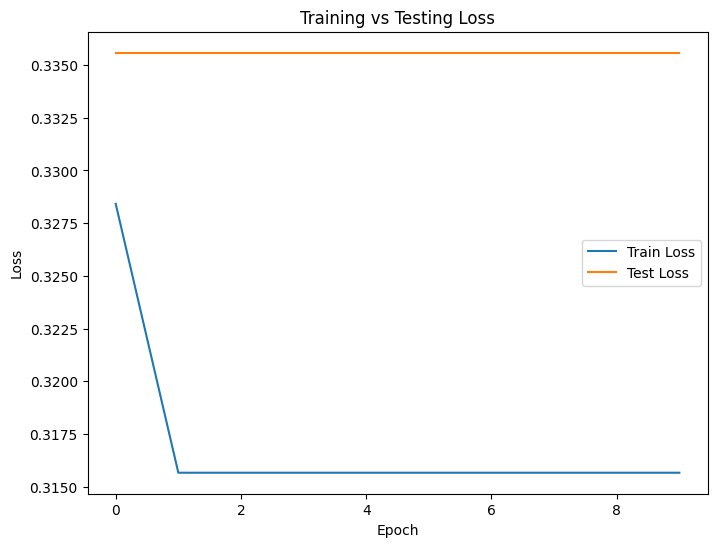

In [ ]:
# Visualisasi hasil training
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Testing Loss')
plt.legend()
plt.show()

In [ ]:
train_losses, test_losses = train_model(
    hidden_layers=1,
    neurons=4,
    activation_fn='sigmoid',
    epochs=1,
    lr=10,
    batch_size=16
    )

Epoch [1/1], Train Loss: 0.3216, Test Loss: 0.3373


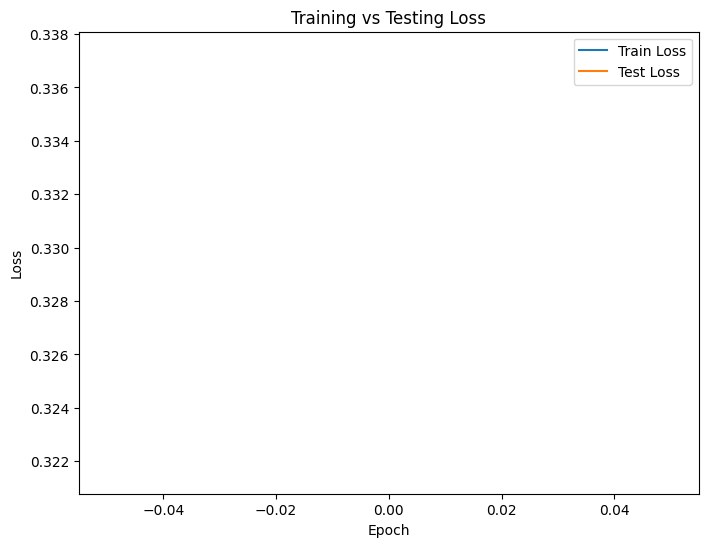

In [ ]:
# Visualisasi hasil training
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Testing Loss')
plt.legend()
plt.show()

In [ ]:
train_losses, test_losses = train_model(
    hidden_layers=3,
    neurons=64,
    activation_fn='linear',
    epochs=100,
    lr=0.0001,
    batch_size=512
    )

Epoch [1/100], Train Loss: 0.6792, Test Loss: 0.6739
Epoch [2/100], Train Loss: 0.6740, Test Loss: 0.6699
Epoch [3/100], Train Loss: 0.6698, Test Loss: 0.6659
Epoch [4/100], Train Loss: 0.6668, Test Loss: 0.6619
Epoch [5/100], Train Loss: 0.6619, Test Loss: 0.6578
Epoch [6/100], Train Loss: 0.6572, Test Loss: 0.6538
Epoch [7/100], Train Loss: 0.6532, Test Loss: 0.6499
Epoch [8/100], Train Loss: 0.6485, Test Loss: 0.6459
Epoch [9/100], Train Loss: 0.6443, Test Loss: 0.6419
Epoch [10/100], Train Loss: 0.6398, Test Loss: 0.6379
Epoch [11/100], Train Loss: 0.6351, Test Loss: 0.6339
Epoch [12/100], Train Loss: 0.6315, Test Loss: 0.6299
Epoch [13/100], Train Loss: 0.6272, Test Loss: 0.6259
Epoch [14/100], Train Loss: 0.6235, Test Loss: 0.6219
Epoch [15/100], Train Loss: 0.6187, Test Loss: 0.6179
Epoch [16/100], Train Loss: 0.6136, Test Loss: 0.6139
Epoch [17/100], Train Loss: 0.6098, Test Loss: 0.6098
Epoch [18/100], Train Loss: 0.6056, Test Loss: 0.6058
Epoch [19/100], Train Loss: 0.6011, T

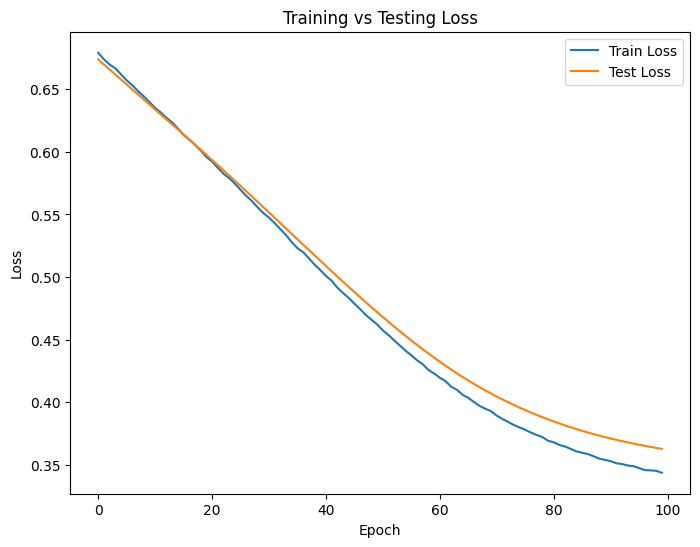

In [ ]:
# Visualisasi hasil training
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Testing Loss')
plt.legend()
plt.show()

In [82]:
train_losses, test_losses = train_model(
    hidden_layers=3,
    neurons=16,
    activation_fn='linear',
    epochs=50,
    lr=0.1,
    batch_size=256
    )

Epoch [1/50], Train Loss: 0.5617, Test Loss: 0.4180
Epoch [2/50], Train Loss: 0.3372, Test Loss: 0.3455
Epoch [3/50], Train Loss: 0.3188, Test Loss: 0.3377
Epoch [4/50], Train Loss: 0.3160, Test Loss: 0.3377
Epoch [5/50], Train Loss: 0.3152, Test Loss: 0.3377
Epoch [6/50], Train Loss: 0.3152, Test Loss: 0.3377
Epoch [7/50], Train Loss: 0.3152, Test Loss: 0.3377
Epoch [8/50], Train Loss: 0.3152, Test Loss: 0.3377
Epoch [9/50], Train Loss: 0.3152, Test Loss: 0.3377
Epoch [10/50], Train Loss: 0.3152, Test Loss: 0.3377
Epoch [11/50], Train Loss: 0.3152, Test Loss: 0.3377
Epoch [12/50], Train Loss: 0.3190, Test Loss: 0.3377
Epoch [13/50], Train Loss: 0.3152, Test Loss: 0.3377
Epoch [14/50], Train Loss: 0.3190, Test Loss: 0.3377
Epoch [15/50], Train Loss: 0.3152, Test Loss: 0.3377
Epoch [16/50], Train Loss: 0.3152, Test Loss: 0.3377
Epoch [17/50], Train Loss: 0.3190, Test Loss: 0.3377
Epoch [18/50], Train Loss: 0.3152, Test Loss: 0.3377
Epoch [19/50], Train Loss: 0.3152, Test Loss: 0.3377
Ep

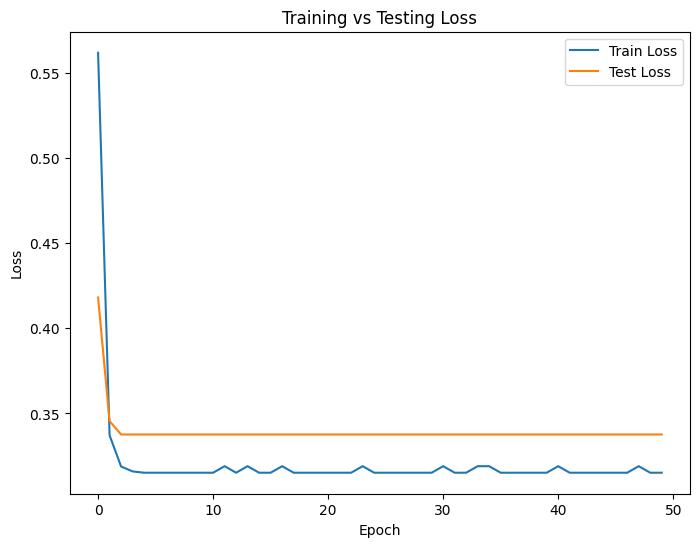

In [83]:
# Visualisasi hasil training
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Testing Loss')
plt.legend()
plt.show()

In [84]:
train_losses, test_losses = train_model(
    hidden_layers=2,
    neurons=64,
    activation_fn='linear',
    epochs=100,
    lr=0.0001,
    batch_size=128
    )

Epoch [1/100], Train Loss: 0.6984, Test Loss: 0.6858
Epoch [2/100], Train Loss: 0.6867, Test Loss: 0.6746
Epoch [3/100], Train Loss: 0.6754, Test Loss: 0.6635
Epoch [4/100], Train Loss: 0.6626, Test Loss: 0.6527
Epoch [5/100], Train Loss: 0.6511, Test Loss: 0.6418
Epoch [6/100], Train Loss: 0.6401, Test Loss: 0.6312
Epoch [7/100], Train Loss: 0.6294, Test Loss: 0.6207
Epoch [8/100], Train Loss: 0.6173, Test Loss: 0.6105
Epoch [9/100], Train Loss: 0.6066, Test Loss: 0.6005
Epoch [10/100], Train Loss: 0.5953, Test Loss: 0.5905
Epoch [11/100], Train Loss: 0.5849, Test Loss: 0.5807
Epoch [12/100], Train Loss: 0.5748, Test Loss: 0.5711
Epoch [13/100], Train Loss: 0.5662, Test Loss: 0.5616
Epoch [14/100], Train Loss: 0.5540, Test Loss: 0.5525
Epoch [15/100], Train Loss: 0.5446, Test Loss: 0.5435
Epoch [16/100], Train Loss: 0.5357, Test Loss: 0.5347
Epoch [17/100], Train Loss: 0.5261, Test Loss: 0.5261
Epoch [18/100], Train Loss: 0.5166, Test Loss: 0.5177
Epoch [19/100], Train Loss: 0.5079, T

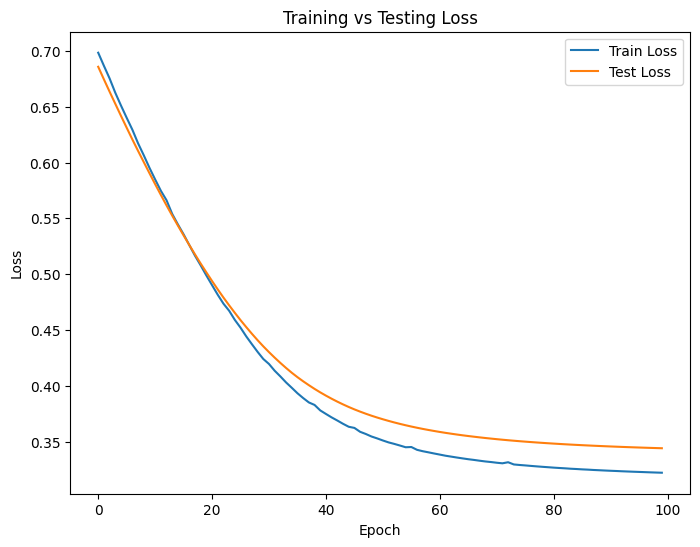

In [85]:
# Visualisasi hasil training
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Testing Loss')
plt.legend()
plt.show()

In [ ]:
train_losses, test_losses = train_model(
    hidden_layers=3,
    neurons=32,
    activation_fn='linear',
    epochs=100,
    lr=0.0001,
    batch_size=64
)

Epoch [1/100], Train Loss: 0.7199, Test Loss: 0.7187
Epoch [2/100], Train Loss: 0.7068, Test Loss: 0.7059
Epoch [3/100], Train Loss: 0.6934, Test Loss: 0.6930
Epoch [4/100], Train Loss: 0.6802, Test Loss: 0.6798
Epoch [5/100], Train Loss: 0.6666, Test Loss: 0.6663
Epoch [6/100], Train Loss: 0.6526, Test Loss: 0.6521
Epoch [7/100], Train Loss: 0.6378, Test Loss: 0.6375
Epoch [8/100], Train Loss: 0.6227, Test Loss: 0.6225
Epoch [9/100], Train Loss: 0.6069, Test Loss: 0.6069
Epoch [10/100], Train Loss: 0.5907, Test Loss: 0.5907
Epoch [11/100], Train Loss: 0.5741, Test Loss: 0.5743
Epoch [12/100], Train Loss: 0.5575, Test Loss: 0.5578
Epoch [13/100], Train Loss: 0.5406, Test Loss: 0.5412
Epoch [14/100], Train Loss: 0.5239, Test Loss: 0.5248
Epoch [15/100], Train Loss: 0.5073, Test Loss: 0.5088
Epoch [16/100], Train Loss: 0.4912, Test Loss: 0.4931
Epoch [17/100], Train Loss: 0.4759, Test Loss: 0.4784
Epoch [18/100], Train Loss: 0.4610, Test Loss: 0.4644
Epoch [19/100], Train Loss: 0.4472, T

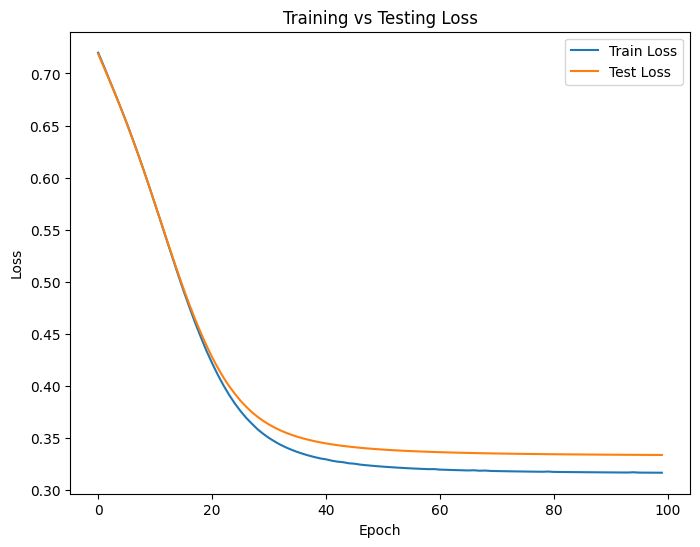

In [ ]:
# Visualisasi hasil training
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Testing Loss')
plt.legend()
plt.show()

In [ ]:
train_losses, test_losses = train_model(
    hidden_layers=2,
    neurons=16,
    activation_fn='linear',
    epochs=50,
    lr=0.001,
    batch_size=32
)

Epoch [1/50], Train Loss: 0.6310, Test Loss: 0.5939
Epoch [2/50], Train Loss: 0.5527, Test Loss: 0.5187
Epoch [3/50], Train Loss: 0.4748, Test Loss: 0.4458
Epoch [4/50], Train Loss: 0.4054, Test Loss: 0.3922
Epoch [5/50], Train Loss: 0.3609, Test Loss: 0.3639
Epoch [6/50], Train Loss: 0.3389, Test Loss: 0.3512
Epoch [7/50], Train Loss: 0.3290, Test Loss: 0.3452
Epoch [8/50], Train Loss: 0.3242, Test Loss: 0.3420
Epoch [9/50], Train Loss: 0.3215, Test Loss: 0.3402
Epoch [10/50], Train Loss: 0.3200, Test Loss: 0.3390
Epoch [11/50], Train Loss: 0.3189, Test Loss: 0.3383
Epoch [12/50], Train Loss: 0.3182, Test Loss: 0.3377
Epoch [13/50], Train Loss: 0.3177, Test Loss: 0.3373
Epoch [14/50], Train Loss: 0.3174, Test Loss: 0.3370
Epoch [15/50], Train Loss: 0.3171, Test Loss: 0.3368
Epoch [16/50], Train Loss: 0.3169, Test Loss: 0.3366
Epoch [17/50], Train Loss: 0.3167, Test Loss: 0.3365
Epoch [18/50], Train Loss: 0.3166, Test Loss: 0.3364
Epoch [19/50], Train Loss: 0.3165, Test Loss: 0.3363
Ep

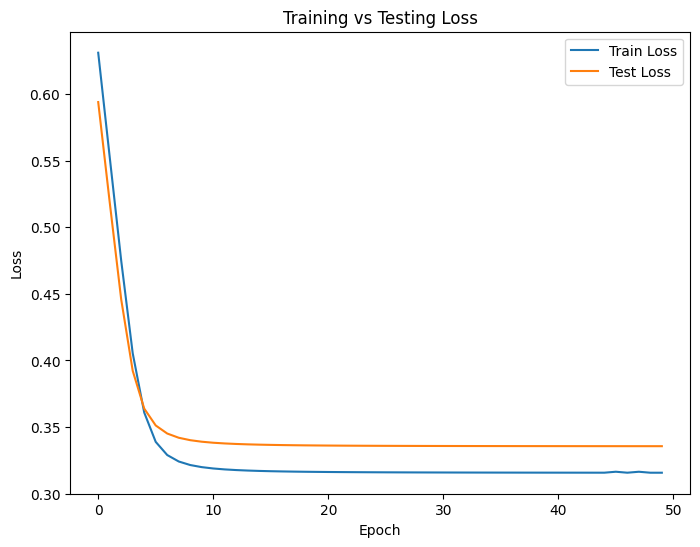

In [ ]:
# Visualisasi hasil training
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Testing Loss')
plt.legend()
plt.show()

In [ ]:
train_losses, test_losses = train_model(
    hidden_layers=1,
    neurons=8,
    activation_fn='tanh',
    epochs=25,
    lr=1,
    batch_size=16
)

Epoch [1/25], Train Loss: 0.3904, Test Loss: 0.3373
Epoch [2/25], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [3/25], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [4/25], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [5/25], Train Loss: 0.3193, Test Loss: 0.3373
Epoch [6/25], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [7/25], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [8/25], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [9/25], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [10/25], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [11/25], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [12/25], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [13/25], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [14/25], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [15/25], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [16/25], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [17/25], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [18/25], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [19/25], Train Loss: 0.3157, Test Loss: 0.3373
Ep

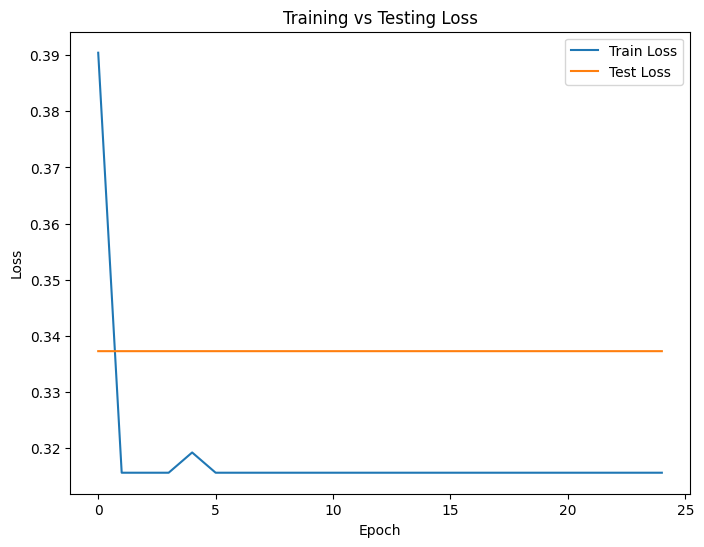

In [ ]:
# Visualisasi hasil training
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Testing Loss')
plt.legend()
plt.show()

In [ ]:
train_losses, test_losses = train_model(
    hidden_layers=2,
    neurons=32,
    activation_fn='relu',
    epochs=50,
    lr=0.01,
    batch_size=64
)

Epoch [1/50], Train Loss: 0.4624, Test Loss: 0.3370
Epoch [2/50], Train Loss: 0.3169, Test Loss: 0.3328
Epoch [3/50], Train Loss: 0.3160, Test Loss: 0.3328
Epoch [4/50], Train Loss: 0.3157, Test Loss: 0.3328
Epoch [5/50], Train Loss: 0.3157, Test Loss: 0.3328
Epoch [6/50], Train Loss: 0.3157, Test Loss: 0.3328
Epoch [7/50], Train Loss: 0.3157, Test Loss: 0.3328
Epoch [8/50], Train Loss: 0.3157, Test Loss: 0.3328
Epoch [9/50], Train Loss: 0.3157, Test Loss: 0.3328
Epoch [10/50], Train Loss: 0.3157, Test Loss: 0.3328
Epoch [11/50], Train Loss: 0.3159, Test Loss: 0.3328
Epoch [12/50], Train Loss: 0.3157, Test Loss: 0.3328
Epoch [13/50], Train Loss: 0.3157, Test Loss: 0.3328
Epoch [14/50], Train Loss: 0.3157, Test Loss: 0.3328
Epoch [15/50], Train Loss: 0.3157, Test Loss: 0.3328
Epoch [16/50], Train Loss: 0.3157, Test Loss: 0.3328
Epoch [17/50], Train Loss: 0.3157, Test Loss: 0.3328
Epoch [18/50], Train Loss: 0.3157, Test Loss: 0.3328
Epoch [19/50], Train Loss: 0.3157, Test Loss: 0.3328
Ep

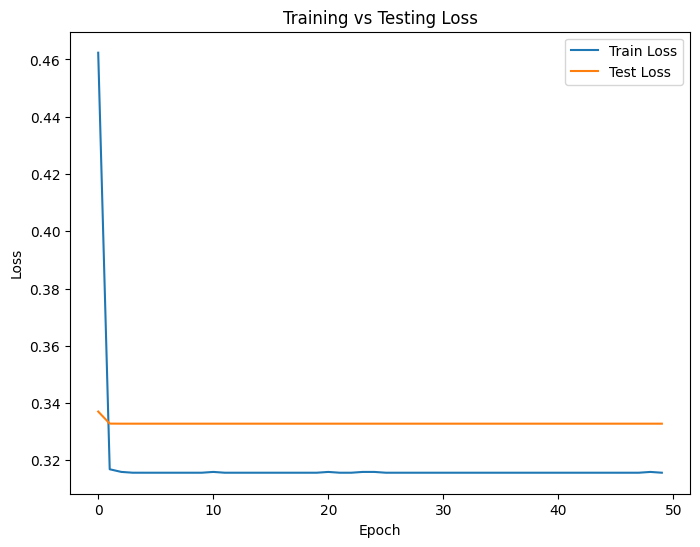

In [ ]:
# Visualisasi hasil training
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Testing Loss')
plt.legend()
plt.show()

In [ ]:
train_losses, test_losses = train_model(
    hidden_layers=1,
    neurons=64,
    activation_fn='sigmoid',
    epochs=100,
    lr=0.001,
    batch_size=32
)

Epoch [1/100], Train Loss: 0.6381, Test Loss: 0.4809
Epoch [2/100], Train Loss: 0.4096, Test Loss: 0.3854
Epoch [3/100], Train Loss: 0.3552, Test Loss: 0.3626
Epoch [4/100], Train Loss: 0.3402, Test Loss: 0.3537
Epoch [5/100], Train Loss: 0.3324, Test Loss: 0.3489
Epoch [6/100], Train Loss: 0.3282, Test Loss: 0.3459
Epoch [7/100], Train Loss: 0.3256, Test Loss: 0.3439
Epoch [8/100], Train Loss: 0.3237, Test Loss: 0.3424
Epoch [9/100], Train Loss: 0.3224, Test Loss: 0.3413
Epoch [10/100], Train Loss: 0.3214, Test Loss: 0.3405
Epoch [11/100], Train Loss: 0.3206, Test Loss: 0.3399
Epoch [12/100], Train Loss: 0.3199, Test Loss: 0.3393
Epoch [13/100], Train Loss: 0.3194, Test Loss: 0.3389
Epoch [14/100], Train Loss: 0.3197, Test Loss: 0.3386
Epoch [15/100], Train Loss: 0.3187, Test Loss: 0.3383
Epoch [16/100], Train Loss: 0.3184, Test Loss: 0.3380
Epoch [17/100], Train Loss: 0.3181, Test Loss: 0.3378
Epoch [18/100], Train Loss: 0.3179, Test Loss: 0.3376
Epoch [19/100], Train Loss: 0.3177, T

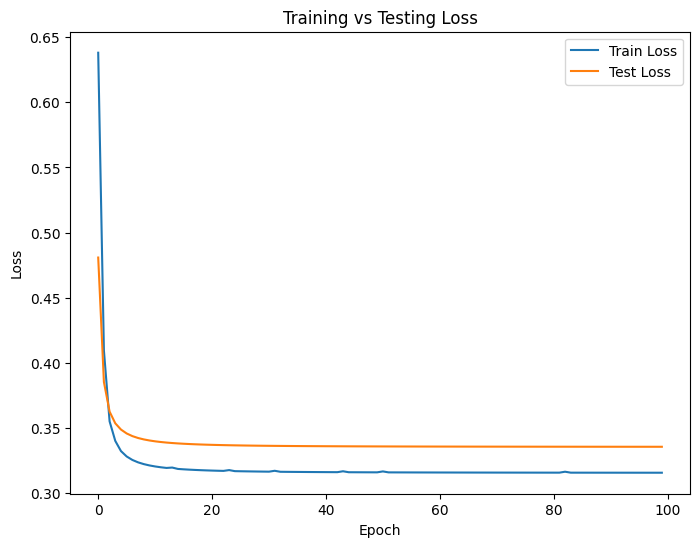

In [ ]:
# Visualisasi hasil training
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Testing Loss')
plt.legend()
plt.show()

In [ ]:
train_losses, test_losses = train_model(
    hidden_layers=1,
    neurons=4,
    activation_fn='tanh',
    epochs=10,
    lr=0.1,
    batch_size=128
)

Epoch [1/10], Train Loss: 0.6400, Test Loss: 0.4186
Epoch [2/10], Train Loss: 0.3512, Test Loss: 0.3441
Epoch [3/10], Train Loss: 0.3188, Test Loss: 0.3392
Epoch [4/10], Train Loss: 0.3162, Test Loss: 0.3383
Epoch [5/10], Train Loss: 0.3157, Test Loss: 0.3381
Epoch [6/10], Train Loss: 0.3156, Test Loss: 0.3381
Epoch [7/10], Train Loss: 0.3156, Test Loss: 0.3381
Epoch [8/10], Train Loss: 0.3156, Test Loss: 0.3380
Epoch [9/10], Train Loss: 0.3156, Test Loss: 0.3380
Epoch [10/10], Train Loss: 0.3156, Test Loss: 0.3380


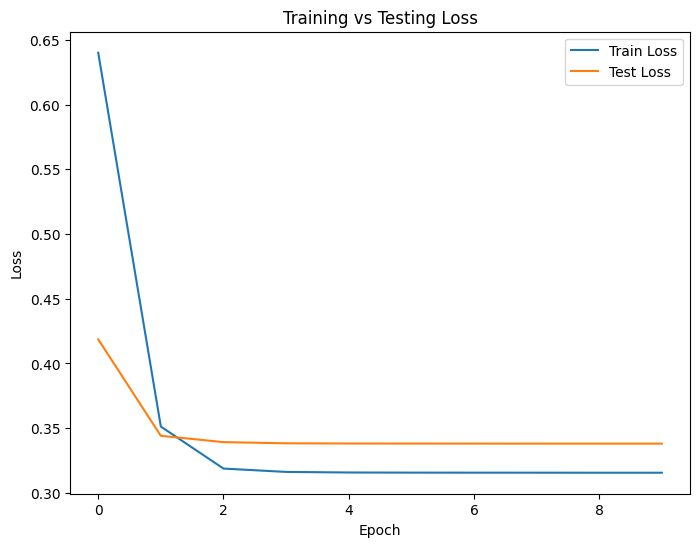

In [ ]:
# Visualisasi hasil training
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Testing Loss')
plt.legend()
plt.show()

In [ ]:
train_losses, test_losses = train_model(
    hidden_layers=1,
    neurons=32,
    activation_fn='relu',
    epochs=50,
    lr=0.1,
    batch_size=128
)

Epoch [1/50], Train Loss: 0.4087, Test Loss: 0.3380
Epoch [2/50], Train Loss: 0.3155, Test Loss: 0.3380
Epoch [3/50], Train Loss: 0.3155, Test Loss: 0.3380
Epoch [4/50], Train Loss: 0.3171, Test Loss: 0.3380
Epoch [5/50], Train Loss: 0.3155, Test Loss: 0.3380
Epoch [6/50], Train Loss: 0.3171, Test Loss: 0.3380
Epoch [7/50], Train Loss: 0.3155, Test Loss: 0.3380
Epoch [8/50], Train Loss: 0.3171, Test Loss: 0.3380
Epoch [9/50], Train Loss: 0.3171, Test Loss: 0.3380
Epoch [10/50], Train Loss: 0.3155, Test Loss: 0.3380
Epoch [11/50], Train Loss: 0.3155, Test Loss: 0.3380
Epoch [12/50], Train Loss: 0.3171, Test Loss: 0.3380
Epoch [13/50], Train Loss: 0.3155, Test Loss: 0.3380
Epoch [14/50], Train Loss: 0.3171, Test Loss: 0.3380
Epoch [15/50], Train Loss: 0.3155, Test Loss: 0.3380
Epoch [16/50], Train Loss: 0.3155, Test Loss: 0.3380
Epoch [17/50], Train Loss: 0.3155, Test Loss: 0.3380
Epoch [18/50], Train Loss: 0.3155, Test Loss: 0.3380
Epoch [19/50], Train Loss: 0.3155, Test Loss: 0.3380
Ep

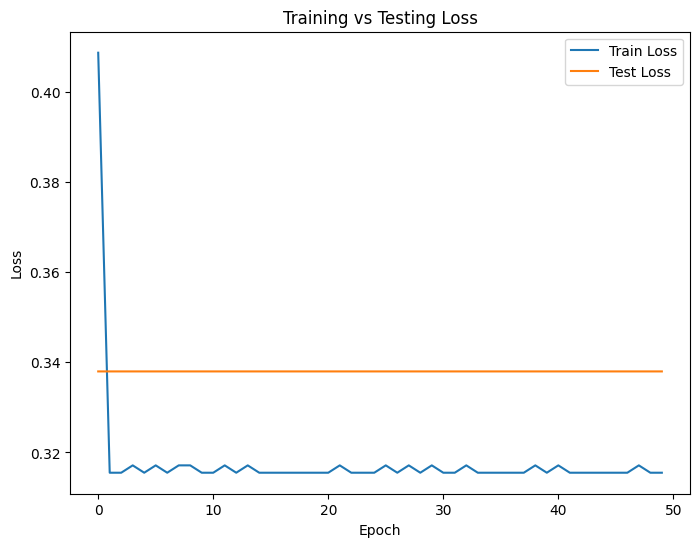

In [ ]:
# Visualisasi hasil training
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Testing Loss')
plt.legend()
plt.show()

In [ ]:
train_losses, test_losses = train_model(
    hidden_layers=1,
    neurons=64,
    activation_fn='relu',
    epochs=50,
    lr=10,
    batch_size=16
)

Epoch [1/50], Train Loss: 0.3218, Test Loss: 0.3373
Epoch [2/50], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [3/50], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [4/50], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [5/50], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [6/50], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [7/50], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [8/50], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [9/50], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [10/50], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [11/50], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [12/50], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [13/50], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [14/50], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [15/50], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [16/50], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [17/50], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [18/50], Train Loss: 0.3157, Test Loss: 0.3373
Epoch [19/50], Train Loss: 0.3157, Test Loss: 0.3373
Ep

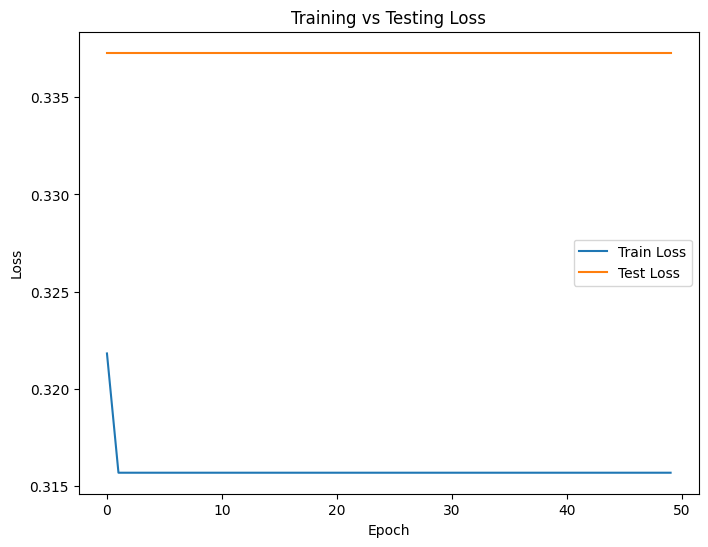

In [ ]:
# Visualisasi hasil training
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Testing Loss')
plt.legend()
plt.show()